# Convert a pretrained Keras model to tensorflow estimator and export it to server

## resources
- [convert keras to tf.estimator](https://cloud.google.com/blog/big-data/2017/12/new-in-tensorflow-14-converting-a-keras-model-to-a-tensorflow-estimator)
- [export keras for serving](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html)
- [keras pretrained model](https://keras.io/applications/)

In [2]:
from pandas.core.computation import expressions  # for the import error

In [3]:
import tensorflow as tf
from tensorflow.contrib.session_bundle import exporter
import numpy as np

# it seems that the native keras package doesnt work with latest tf yet
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

<class 'PIL.Image.Image'>


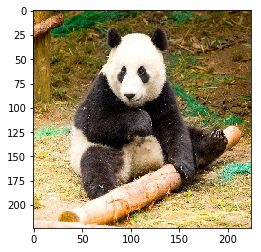

In [4]:
img = keras.preprocessing.image.load_img('./panda.jpg', target_size=[224, 224])
plt.imshow(img)
print(type(img))

## test with keras model

In [5]:
imgs = keras.applications.resnet50.preprocess_input(np.expand_dims(keras.preprocessing.image.img_to_array(img), 0), )
keras_model = keras.applications.ResNet50()
keras_model.compile(optimizer='adam', loss=keras.metrics.categorical_crossentropy)

labels = keras_model.predict(imgs)
keras.applications.resnet50.decode_predictions(labels)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


[[('n02510455', 'giant_panda', 0.9956606),
  ('n02133161', 'American_black_bear', 0.0018819695),
  ('n02509815', 'lesser_panda', 0.0009390237),
  ('n02500267', 'indri', 0.0002923009),
  ('n02106166', 'Border_collie', 0.0001404176)]]

## convert keras model to tf.estimator

In [6]:
type(keras_model)

tensorflow.python.keras._impl.keras.engine.training.Model

In [7]:
tf_model = keras.estimator.model_to_estimator(keras_model, model_dir="./converted_tf_model/")

INFO:tensorflow:Using the Keras model from memory.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './converted_tf_model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1258b0978>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
tf_model.model_dir

'./converted_tf_model/'

In [9]:
!ls $tf_model.model_dir

checkpoint                           keras_model.ckpt.index
keras_model.ckpt.data-00000-of-00001 keras_model.ckpt.meta


## test converted tf estimiator model

In [34]:
keras_model.input_names, keras_model.output_names

(['input_1'], ['fc1000'])

In [35]:
r = list(tf_model.predict(input_fn=tf.estimator.inputs.numpy_input_fn({'input_1':imgs}, shuffle=False) ))
labels = r[0]['fc1000']

INFO:tensorflow:Restoring parameters from ./converted_tf_model/keras_model.ckpt


In [47]:
keras.applications.resnet50.decode_predictions(labels.reshape(1, -1))

[[('n02510455', 'giant_panda', 0.9956606),
  ('n02133161', 'American_black_bear', 0.0018819695),
  ('n02509815', 'lesser_panda', 0.0009390237),
  ('n02500267', 'indri', 0.0002923009),
  ('n02106166', 'Border_collie', 0.0001404176)]]

## export the estimator for serving

In [54]:
export_path = './exported_model'
if tf.gfile.Exists(export_path):
    tf.gfile.DeleteRecursively(export_path)

serving_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    {'input_1': tf.placeholder(tf.float32, shape=[None, 224, 224, 3])}, 
    default_batch_size=1)


In [55]:
tf_model.export_savedmodel(export_path, serving_input_receiver_fn=serving_input_fn)

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Restoring parameters from ./converted_tf_model/keras_model.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b"./exported_model/temp-b'1518591928'/saved_model.pb"


b'./exported_model/1518591928'

In [59]:
!ls exported_model/1518591928/

saved_model.pb variables


In [70]:
from tensorflow.python.tools import inspect_checkpoint

In [ ]:
inspect_checkpoint.print_tensors_in_checkpoint_file('./converted_tf_model/keras_model.ckpt', all_tensor_names=True,
                                                    tensor_name='', 
                                                    all_tensors=True)